In [1]:
import pandas as pd
import json
import os
import numpy as np
import torch
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import random
import networkx as nx
import matplotlib.pyplot as plt

c:\Users\hkathuri\Downloads\alarm\solara\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
folder_path = 'arxiv_datasets'


In [3]:
# List all files in the folder
all_files = os.listdir(folder_path)

csv_files = [file for file in all_files if file.endswith('.csv')]

dataframes = [pd.read_csv(os.path.join(folder_path, file)) for file in csv_files]

combined_df = pd.concat(dataframes, ignore_index=True)

C:\Users\hkathuri\AppData\Local\Temp\ipykernel_31532\2372850592.py:8: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes = [pd.read_csv(os.path.join(folder_path, file)) for file in csv_files]
C:\Users\hkathuri\AppData\Local\Temp\ipykernel_31532\2372850592.py:8: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes = [pd.read_csv(os.path.join(folder_path, file)) for file in csv_files]
C:\Users\hkathuri\AppData\Local\Temp\ipykernel_31532\2372850592.py:8: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes = [pd.read_csv(os.path.join(folder_path, file)) for file in csv_files]
C:\Users\hkathuri\AppData\Local\Temp\ipykernel_31532\2372850592.py:8: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes = [pd.read_csv(os.path.join(folder_path, file)) for fil

In [4]:

# Filter the DataFrame for papers created between 2000 and 2010
filtered_df = combined_df[(combined_df['created'] >= '2000-01-01') & (combined_df['created'] < '2011-01-01')]



In [5]:

filtered_df = filtered_df.sample(n=1000, random_state=42)

In [6]:

# using our model, which is a bert based model for embedding
model = SentenceTransformer('all-MiniLM-L6-v2')
filtered_df['embeddings'] = filtered_df['abstract'].apply(lambda x: model.encode(x))


In [7]:
# resetting index
filtered_df = filtered_df.reset_index(drop=True)

In [8]:

embeddings_array = np.vstack(filtered_df['embeddings'].values)


In [9]:
# sampling 1000
sample_size = 1000
sample_indices = random.sample(range(len(embeddings_array)), sample_size)
sample_embeddings = embeddings_array[sample_indices]

In [10]:

sample_cosine_sim = cosine_similarity(sample_embeddings)


In [11]:
# flatten the matrix and remove self-similarities 
sample_similarities = sample_cosine_sim[np.triu_indices(sample_size, k=1)]


In [12]:
threshold = np.percentile(sample_similarities, 90)

In [13]:
# im just constructing a graph here atm

G = nx.Graph()

In [15]:

G = nx.Graph()

for i in range(len(embeddings_array)):
    G.add_node(i)

bert_cosine_sim = cosine_similarity(embeddings_array)


In [16]:

for i, row in enumerate(bert_cosine_sim):
    similar_nodes = np.where((row >= threshold) & (row < 1.0))[0]
    for node1 in similar_nodes:
        for node2 in similar_nodes:
            if node1 != node2:
                G.add_edge(node1, node2)


In [20]:
from sklearn.cluster import KMeans

n_clusters = len(filtered_df['categories'].unique())  

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
predicted_clusters = kmeans.fit_predict(embeddings_array)


In [21]:
predicted_clusters

array([309, 125, 213, 118, 272, 296, 217, 208, 165, 117, 336,   5, 338,
        60, 362,  82, 168, 259, 126,  23,  37, 145,  30, 128, 298,  36,
       192, 265, 321, 111, 160, 121, 123, 245,  19, 118,  17, 327, 154,
        68,  72, 113, 171,  48,  50,  64,   5, 295, 165, 290, 175, 286,
       245,  64,  66,  93, 119,  30,  44,  88, 240, 298, 144, 365,  12,
       104, 170, 257, 119, 115,  56, 181,  71, 110,  21,   8, 100, 185,
        96,  16,  31, 125, 117, 303, 128, 121, 279, 144, 252, 160,  80,
        59, 288, 224, 225,  85,  37, 270, 139,  53,  89, 348, 204, 248,
       330,  89, 141, 228, 292, 117,  65, 314, 100,  96, 292,  62, 100,
       330, 197,  92, 119, 104, 266, 334, 103, 236, 212,  99,  29,  56,
       117,  45, 171, 306, 178, 280, 168, 351,  72,  15, 207, 106, 204,
       189, 100,  98,  91, 349,  44,  37, 248, 316, 143, 119,  19,  78,
        29, 316, 100, 252, 119,  73, 290, 156, 280, 117, 129,  64,  29,
       134, 150, 158,  56,  67, 213, 136, 219, 127, 112,   2,   

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = filtered_df['categories'].values

# cluster_confusion_matrix = confusion_matrix(y_true, predicted_clusters)

# cluster_confusion_matrix_normalized = cluster_confusion_matrix.astype('float') / cluster_confusion_matrix.sum(axis=1)[:, np.newaxis]


In [24]:
assert len(y_true) == len(predicted_clusters), "y_true and predicted_clusters must have the same length"


In [25]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(y_true)


In [26]:
from sklearn.metrics import confusion_matrix

cluster_confusion_matrix = confusion_matrix(y_true_encoded, predicted_clusters)

cluster_confusion_matrix_normalized = cluster_confusion_matrix.astype('float') / cluster_confusion_matrix.sum(axis=1)[:, np.newaxis]


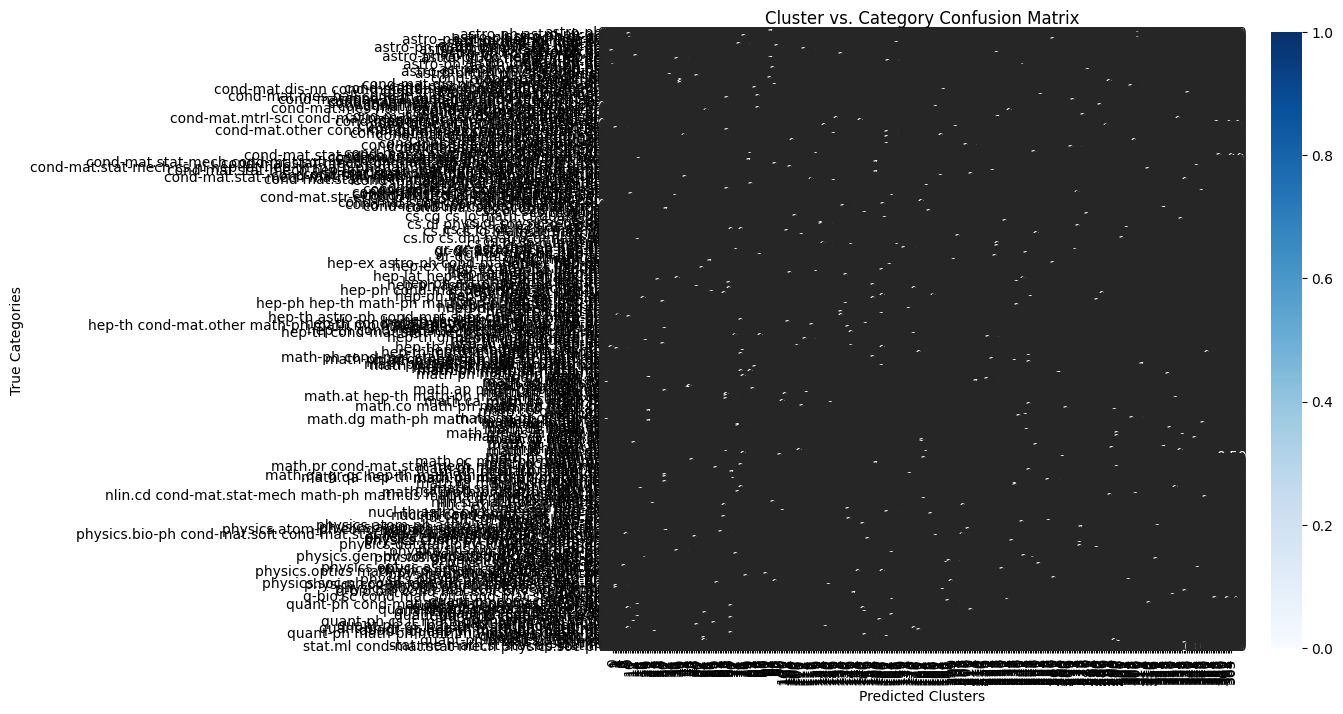

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(cluster_confusion_matrix_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=range(n_clusters), yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Clusters")
plt.ylabel("True Categories")
plt.title("Cluster vs. Category Confusion Matrix")
plt.show()


In [17]:
# Step 5: Calculate proportions based on ground truth categories
proportions = []

unique_categories = filtered_df['categories'].unique()

for category in unique_categories:
    cluster_proportions = []
    cluster_indices = filtered_df.index[filtered_df['categories'] == category].tolist()
    
    for node in cluster_indices:
        # getting neighbors
        bert_neighbors = set([n for n in G.neighbors(node)])
        
        same_category_neighbors = bert_neighbors & set(cluster_indices)
        
        if len(bert_neighbors) > 0:
            proportion = len(same_category_neighbors) / len(bert_neighbors)
            cluster_proportions.append(proportion)
    
    if len(cluster_proportions) > 0:
        cluster_avg_proportion = sum(cluster_proportions) / len(cluster_proportions)
        proportions.append(cluster_avg_proportion)


In [18]:
# Sgetting proportion to check how much they;re related
if len(proportions) > 0:
    overall_average_proportion = sum(proportions) / len(proportions)
    print("Overall Average Proportion:", overall_average_proportion)


Overall Average Proportion: 0.002952158022929655


In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# Create a confusion matrix
cluster_confusion_matrix = confusion_matrix(y_true, predicted_clusters)

# Normalize the confusion matrix by row (to get proportions)
cluster_confusion_matrix_normalized = cluster_confusion_matrix.astype('float') / cluster_confusion_matrix.sum(axis=1)[:, np.newaxis]


NameError: name 'y_true' is not defined

In [ ]:
# Visualize the normalized confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_confusion_matrix_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=unique_predicted_clusters, yticklabels=unique_categories)
plt.xlabel("Predicted Clusters")
plt.ylabel("True Categories")
plt.title("Cluster Confusion Matrix")
plt.show()


In [37]:
for i, embedding in enumerate(filtered_df['embeddings']):
    G.add_node(i)

# Compute the cosine similarity matrix for all embeddings
cosine_sim = cosine_similarity(embeddings_array)

# Form hyperedges based on the threshold
hyperedges = []
for i, row in enumerate(cosine_sim):
    # Get indices of all nodes that have a cosine similarity above the threshold
    similar_nodes = np.where((row >= threshold) & (row < 1.0))[0]
    
    # If there are multiple similar nodes, they form a hyperedge
    if len(similar_nodes) > 1:
        hyperedges.append(similar_nodes.tolist())

# Add hyperedges to the graph as cliques (each hyperedge is a fully connected subgraph)
for hyperedge in hyperedges:
    for node1 in hyperedge:
        for node2 in hyperedge:
            if node1 != node2:
                G.add_edge(node1, node2)




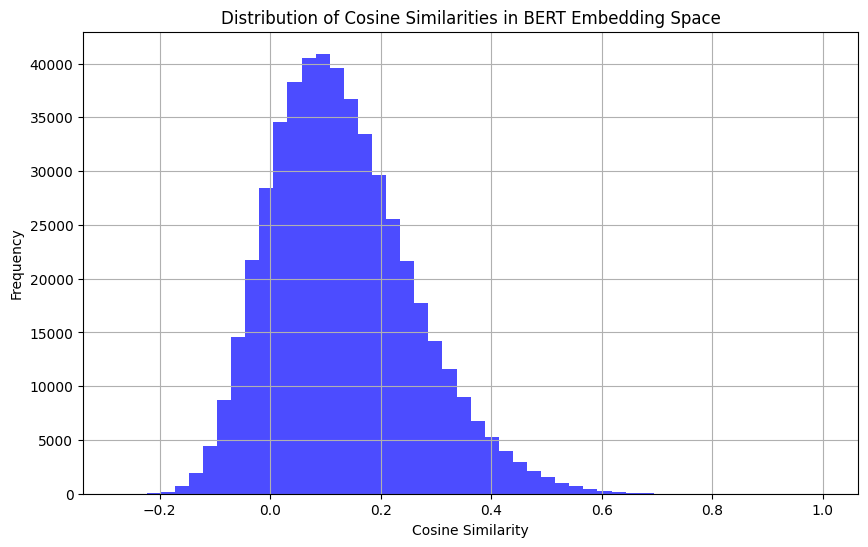

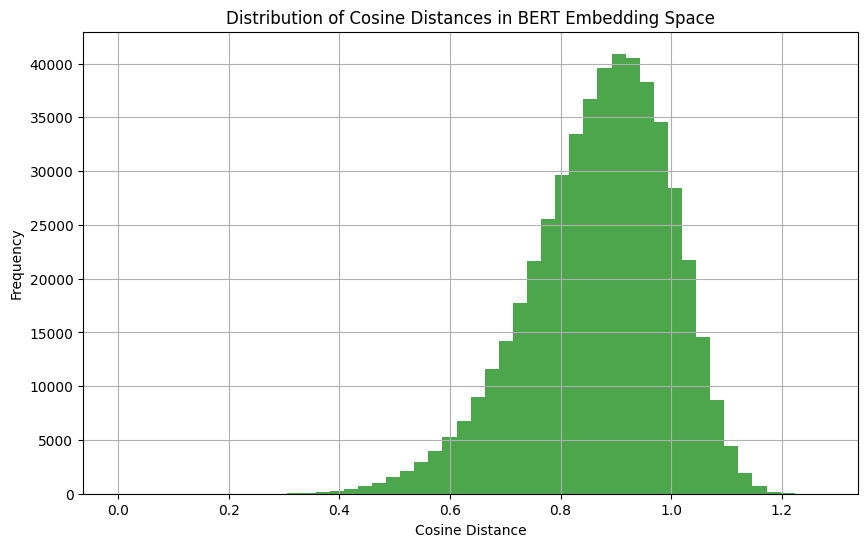

C:\Users\hkathuri\AppData\Local\Temp\ipykernel_4308\2717681003.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cosine_distances, shade=True, color='green')


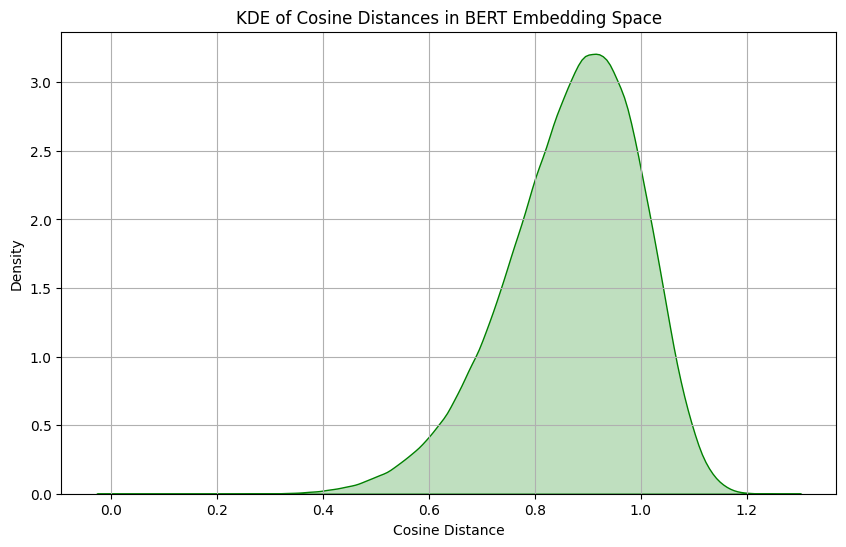

In [40]:
import seaborn as sns

# Extract the upper triangular part of the cosine similarity matrix (excluding the diagonal)
upper_tri_indices = np.triu_indices_from(cosine_sim, k=1)
cosine_similarities = cosine_sim[upper_tri_indices]

# Optionally convert cosine similarities to cosine distances
cosine_distances = 1 - cosine_similarities

# Plot the distribution of cosine similarities
plt.figure(figsize=(10, 6))
plt.hist(cosine_similarities, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Cosine Similarities in BERT Embedding Space")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Optionally, plot the distribution of cosine distances
plt.figure(figsize=(10, 6))
plt.hist(cosine_distances, bins=50, color='green', alpha=0.7)
plt.title("Distribution of Cosine Distances in BERT Embedding Space")
plt.xlabel("Cosine Distance")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Optionally, plot KDE of cosine distances
plt.figure(figsize=(10, 6))
sns.kdeplot(cosine_distances, shade=True, color='green')
plt.title("KDE of Cosine Distances in BERT Embedding Space")
plt.xlabel("Cosine Distance")
plt.ylabel("Density")
plt.grid(True)
plt.show()

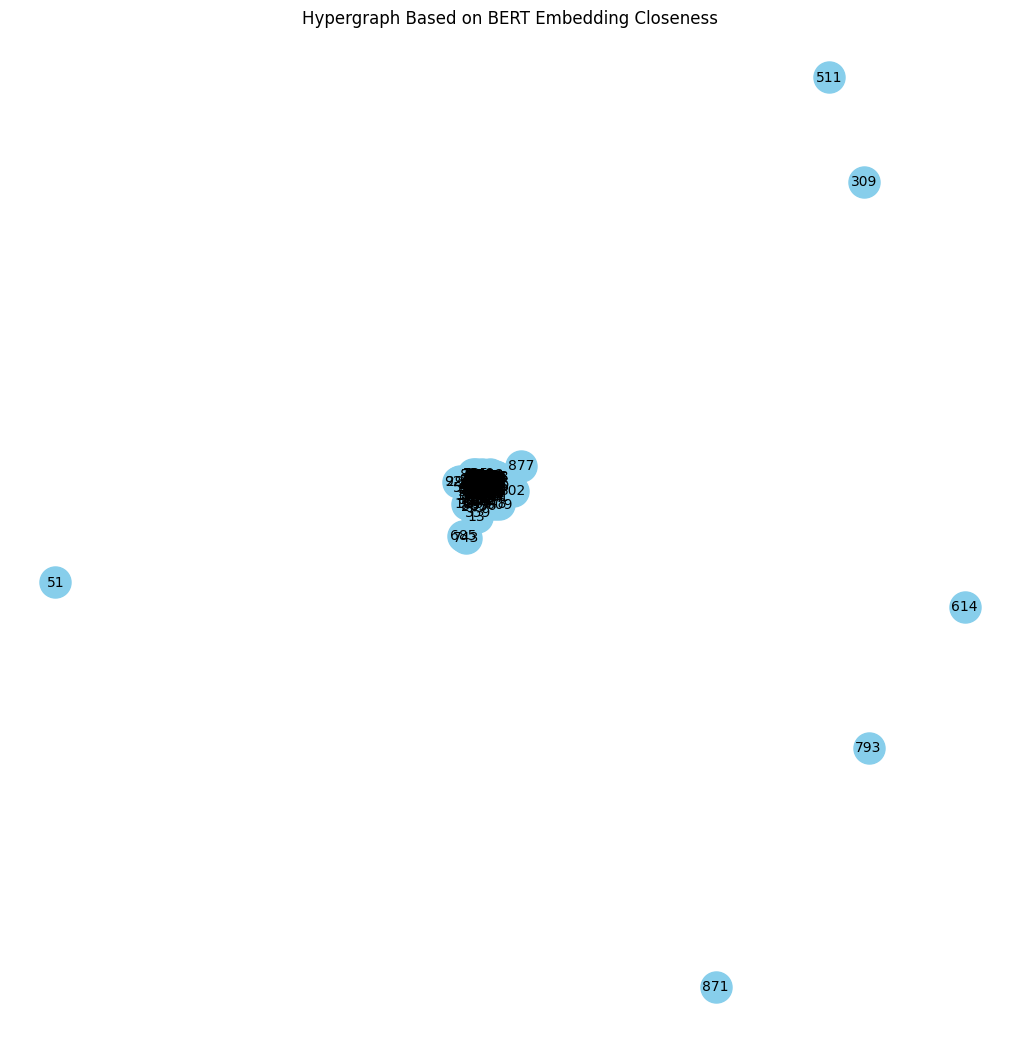

In [38]:

# Set the layout for the graph
pos = nx.spring_layout(G, seed=42)  

plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, font_size=10, font_color='black')
plt.title('Hypergraph Based on BERT Embedding Closeness') #not a hypergraph  but still
plt.show()